In [2]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2, os
import torchvision.transforms as transforms
import matplotlib.patches as patches
import random
import colorsys

In [3]:
# For training Faster R-cnn; Object detection 
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
# output = model(images, targets)

# For inference
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COCO_PERSON_KEYPOINT_NAMES = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle'
]

In [5]:
n_cls_preds = len(COCO_INSTANCE_CATEGORY_NAMES)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
bbox_colors = random.sample(colors, n_cls_preds)

In [6]:
IMAGE_DIR = r"C:\Users\ABansal4\Downloads\pytorch-getting-started\Keypoints-of-humanpose-with-Mask-R-CNN\images"
file= "000000000885.jpg"
filepath = os.path.join(IMAGE_DIR, file)

image = Image.open(filepath)
image = torch.Tensor(np.array(image)).permute(2, 0, 1)    #Pytorch expects NCHW format
image /= 255                                    # Image channels have to be in range (0-1)

In [7]:
def plot_image(image):
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(image.permute(1,2,0))
    return ax

In [8]:
def filter_predictions(prediction, conf_thres = 0.5, iou_threshold = 0.5):
    conf_mask = prediction[:, -1] > conf_thres
    prediction = prediction[conf_mask]

    nms_filter = torchvision.ops.nms(boxes=prediction[:, :4], scores=prediction[:, -1], iou_threshold=iou_threshold)
    prediction = prediction[nms_filter]
    
    return prediction

## Object Detection

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

### pytorch to onnx

In [9]:
with torch.no_grad():
    model.eval()
    predictions = model([image])
    predictions = predictions[0]
#     print(predictions)

In [221]:
prediction = torch.cat((predictions['boxes'], predictions['labels'].float().unsqueeze(dim=1), predictions['scores'].unsqueeze(dim=1)), dim=1)

In [42]:
# plt.figure()
# fig, ax = plt.subplots(1, figsize=(12,9))
# ax.imshow(image.permute(1,2,0))

def plot_boxes(image, prediction):
    ax = plot_image(image) 
    for i, (x1, y1, x2, y2, cls_pred, cls_conf) in enumerate(prediction):
        cls_pred = cls_pred.int()
        box_h = y2 - y1
        box_w = x2 - x1
    #     print(i, COCO_INSTANCE_CATEGORY_NAMES[cls_pred])
        color = bbox_colors[cls_pred]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        text = COCO_INSTANCE_CATEGORY_NAMES[cls_pred] + ':' + "{:.2f}".format(cls_conf.item())
        plt.text(x1, y1, s=text, color='white',
                 verticalalignment='top', bbox={'color': color, 'pad': 0})

#     plt.axis('off')

    plt.savefig(filepath.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
    return ax

<Figure size 432x288 with 0 Axes>

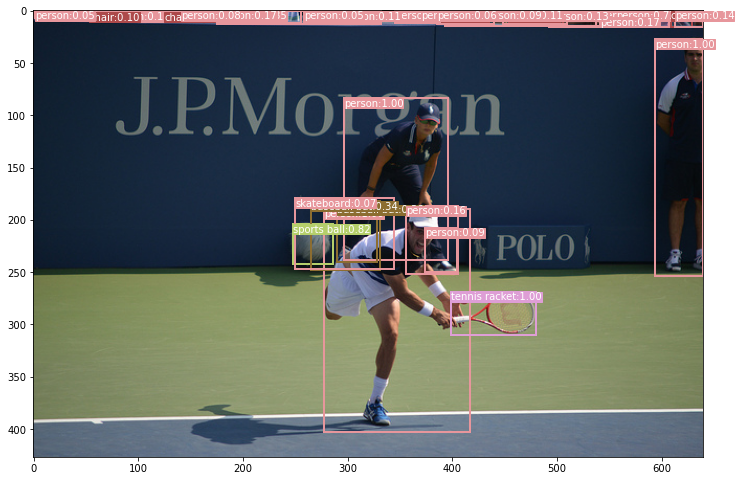

In [43]:
ax = plot_boxes(image, prediction)
# plt.show()

## Object Masking

In [12]:
model_mask = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [13]:
with torch.no_grad():
    model_mask.eval()
    predictions = model_mask([image])
    predictions = predictions[0]
#     print(predictions)

In [14]:
prediction = torch.cat((predictions['boxes'], predictions['labels'].float().unsqueeze(dim=1), predictions['scores'].unsqueeze(dim=1)), dim=1)

In [196]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

colors = random_colors(len(COCO_INSTANCE_CATEGORY_NAMES))

In [190]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image (Tensor NCHW).
    """
    img_new = np.zeros(shape=image.shape)
    for c in range(3):
        img_new[c, :, :] = np.where(mask > 0.5, image[c, :, :] * (1 - alpha) + alpha * color[c], image[c, :, :])
    
    img_new = torch.Tensor(img_new)
    return img_new

<Figure size 432x288 with 0 Axes>

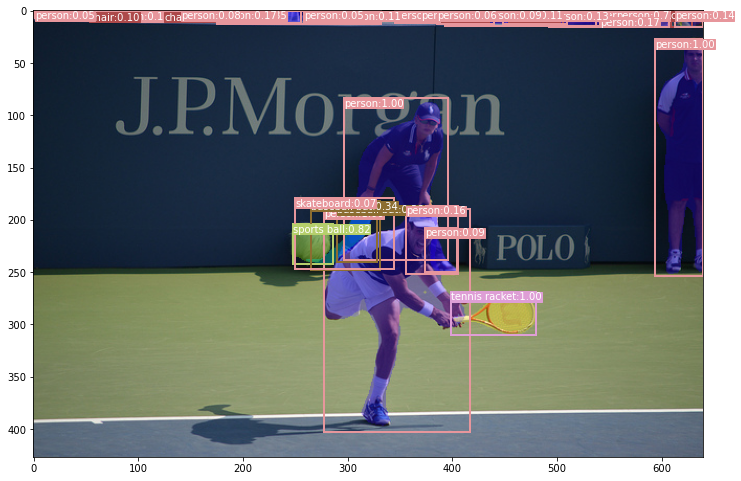

In [210]:
def add_masks(image, predictions):
    img_new = image
    for mask, label in zip(predictions['masks'], predictions['labels']):
        img_new = apply_mask(img_new, mask, colors[label], alpha=0.3)
    
    return img_new

plot_boxes(img_new, prediction)

## Human Keypoint 

In [211]:
model_keyPoint = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

In [212]:
with torch.no_grad():
    model_keyPoint.eval()
    predictions = model_keyPoint([image])
    predictions = predictions[0]
    print(predictions)

{'boxes': tensor([[2.7238e+02, 1.9119e+02, 4.1648e+02, 3.9923e+02],
        [5.9522e+02, 2.6118e+01, 6.3957e+02, 2.4947e+02],
        [3.0188e+02, 8.7762e+01, 3.9450e+02, 2.2429e+02],
        [4.1431e+02, 0.0000e+00, 4.6914e+02, 1.4603e+01],
        [2.6185e+02, 0.0000e+00, 3.3326e+02, 1.3525e+01],
        [4.9955e+02, 0.0000e+00, 5.5223e+02, 1.5047e+01],
        [5.3924e+02, 2.7712e-02, 6.1487e+02, 1.6050e+01],
        [1.0892e+01, 0.0000e+00, 5.5290e+01, 8.4728e+00],
        [3.7351e+02, 1.0341e+00, 3.9659e+02, 1.2301e+01],
        [3.4695e+02, 0.0000e+00, 3.8515e+02, 1.1502e+01],
        [1.8351e+02, 0.0000e+00, 2.5527e+02, 1.1656e+01],
        [1.1022e+02, 0.0000e+00, 1.7256e+02, 9.9940e+00],
        [4.6148e+02, 2.6850e-01, 5.0834e+02, 1.3608e+01],
        [6.0158e+02, 1.3852e+02, 6.3978e+02, 2.4915e+02],
        [5.4127e+02, 2.7262e-01, 5.8246e+02, 1.4539e+01],
        [6.2174e+02, 5.6842e-01, 6.3998e+02, 1.4647e+01],
        [2.8414e+02, 9.0956e+01, 4.1191e+02, 3.2894e+02],
    

In [219]:
prediction = torch.cat((predictions['boxes'], predictions['labels'].float().unsqueeze(dim=1), predictions['scores'].unsqueeze(dim=1)), dim=1)

AttributeError: 'Line2D' object has no property 's'

<Figure size 432x288 with 0 Axes>

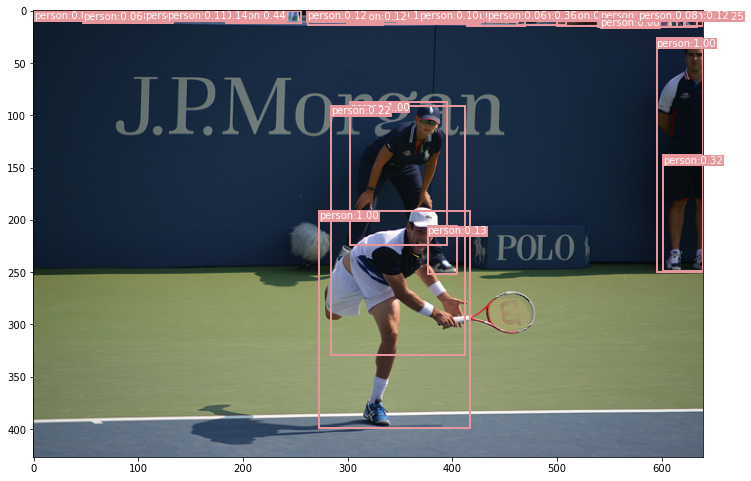

In [237]:
ax = plot_image(image) 
for i, (x1, y1, x2, y2, cls_pred, cls_conf) in enumerate(prediction):
    cls_pred = cls_pred.int()
    box_h = y2 - y1
    box_w = x2 - x1
#     print(i, COCO_INSTANCE_CATEGORY_NAMES[cls_pred])
    color = bbox_colors[cls_pred]
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    text = COCO_INSTANCE_CATEGORY_NAMES[cls_pred] + ':' + "{:.2f}".format(cls_conf.item())
    plt.text(x1, y1, s=text, color='white',
             verticalalignment='top', bbox={'color': color, 'pad': 0})

plt.plot(100, 100, marker="o", c=colors[10])
#     plt.axis('off')

plt.savefig(filepath.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)

In [224]:
colors = random_colors(len(COCO_PERSON_KEYPOINT_NAMES))

In [228]:
ax.plot(100, 100, colors[0])
plt.show()

In [238]:
predictions['keypoints'].shape

torch.Size([33, 17, 3])

In [217]:
len(COCO_PERSON_KEYPOINT_NAMES)

17